# Titanic Dataset Survival Prediction
The below is a short analysis of the Titanic data set available on Kaggle.com. There are two main goals of this analysis:
1. To create a simple logistic regression model to predict survival.
2. To assess how different methods of imputation of the `Age` variable affect model performance.

## Table of contents:
<ol type="I">
    <li><a href=#Information-about-the-data>Information about the data</a></li>
    <li><a href=#Data-dictionary>Data dictionary</a></li>
    <li><a href=#Variable-notes>Variable notes</a></li>
    <li><a href=#Analysis-start>Analysis start</a></li>
    <ol type='i'>
        <li><a href=#Assess-for-missing-data-using-Seaborn's-heatmap.>Assess for missing data</a></li>
        <li><a href=#Start-model-building>Start model building</a></li>
        <li><a href=#Clean-the-data-set>Clean the data set</a></li>
        <li><a href=#Reassess-missingness>Reassess missingness</a></li>
        <li><a href=#Different-imputation-methods>Different imputation methods</a></li>
        <li><a href=#Simple-mean-imputation>Simple mean imputation</a></li>
        <li><a href=#Imputation-by-mean-age-stratified-by-class>Imputation by mean age stratified by class</a></li>
    </ol>
</ol>

Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Generate inline figures.

In [2]:
%matplotlib inline

## Information about the data

> The below text is adapted from the Kaggle Titanic Competition.

The data has been split into two groups:
- training set (`train.csv`)
- test set (`test.csv`)

The training will be used to build the below machine learning model. It contains the outcome information (also known as the “ground truth”) for each passenger. 

The test will be used to assess model performance. The test set does not include the ground truth for each passenger. The trained model will predict whether or not a passenger survived.

## Data dictionary
| Variable |                 Definition                 |                       Key                      |
|:--------:|:------------------------------------------:|:----------------------------------------------:|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

## Variable notes

**pclass:** A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

**age:** 
- Fractional if less than 1. 
- If the age is estimated, is it in the form of xx.5

**sibsp:** The dataset defines family relations in this way:
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way:
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

## Analysis start
Read in the data.

In [3]:
titanic_train = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

Look at the data.

In [4]:
titanic_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
titanic_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


### Assess for missing data using Seaborn's heatmap. 

The heatmap columns correspond to the columns of the training data set. By calling `.isnull()` on the `DataFrame`, a matrix of Boolean values is generated. This is then plotted with a heatmap showing missing data (below).

<AxesSubplot:>

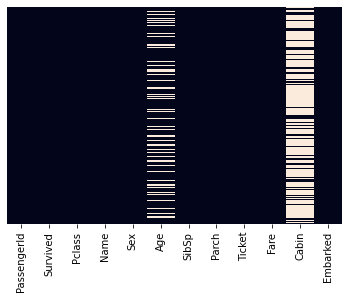

In [6]:
sns.heatmap(data=titanic_train.isnull(), yticklabels=False, cbar=False)

The above shows that the `Age` and `Cabin` columns have missing data. The proportion of missing data for each is:

In [7]:
age_proportion = sum(titanic_train['Age'].isnull()) / len(titanic_train['Age'])
cabin_proportion = sum(titanic_train['Cabin'].isnull()) / len(titanic_train['Cabin'])
print(" Age missing proportion: ", np.round(age_proportion, decimals=3), "\n",
      "Cabin missing proportion: ", np.round(cabin_proportion, decimals=3))

 Age missing proportion:  0.199 
 Cabin missing proportion:  0.771


There is a much larger proportion of missing cabin data than age data. The age missing proportion is amenable to filling in by imputation. Different imputation methods may change the performance of a trained algorithm. In order to assess these differences quickly and easily, we will start by training a simple logistic regression model as assessing its performance.

### Start model building

Import logistic regression.

In [8]:
from sklearn.linear_model import LogisticRegression

Instantiate a logistic regression model.

In [9]:
log_model = LogisticRegression()

### Clean the data set

Remove columns that will not be used for training.

In [10]:
titanic_train_new = titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
titanic_train_new.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


The `Pclass`, `Sex`, and `Embarked` columns are categorical variables that need to be modified with dummy variables in order to train the logistic regression model.

In [11]:
pclass_dummies = pd.get_dummies(titanic_train_new['Pclass'], prefix="Pclass", drop_first=True)
sex_dummies = pd.get_dummies(titanic_train_new['Sex'], drop_first=True)
embarked_dummies = pd.get_dummies(titanic_train_new['Embarked'], drop_first=True)

Add the dummy variables to the data frame.

In [12]:
titanic_train_new = pd.concat([titanic_train_new, pclass_dummies, sex_dummies, embarked_dummies],
                              axis=1)

Drop the columns that are no longer needed.

In [13]:
# The Pclass column will be required below for the imputation, so is not dropped here.
titanic_train_new.drop(['Sex', 'Embarked'], axis=1, inplace=True)

### Reassess missingness

<AxesSubplot:>

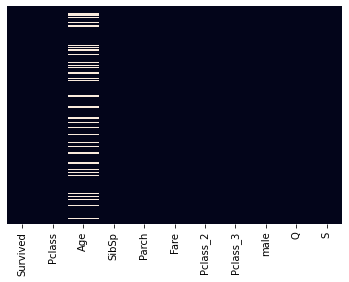

In [14]:
sns.heatmap(data=titanic_train_new.isnull(), yticklabels=False, cbar=False)

### Different imputation methods

Three imputation methods will be used to generate three different data sets. Each of these subsequent data sets will then be used to train a model and predict on the held-out test data. Performance of the each model will be assessed to distinguish how each type of imputation affects model performance.

Imputations methods:  
1. [Simple mean imputation](#Simple-mean-imputation)  
2. [Imputation by mean age stratified by class](#Imputation-by-mean-age-stratified-by-class)  
4. [Nearest neighbors imputation&mdash;build in `sklearn`](#KNN-imputation)  
3. [Multivariate feature imputation&mdash;experimental `sklearn` feature](#Multivariate-feature-imputation)  


Each imputation methods will have a different effect on the distribution of the original variable. This will be assessed using a simple histogram with an overlying kernel density estimate.

### Simple mean imputation
Impute the age by inserting mean age.

Define a function to apply to the data frame.

In [15]:
def impute_mean(age):
    if np.isnan(age):
        return titanic_train_new['Age'].mean()
    else:
        return age

Apply the mean imputation function.

In [16]:
titanic_train_new['age_mean_imputed'] = titanic_train_new['Age'].apply(impute_mean)

Plot the resulting imputation histogram.

Text(0.5, 1.0, 'Mean Age Imputation')

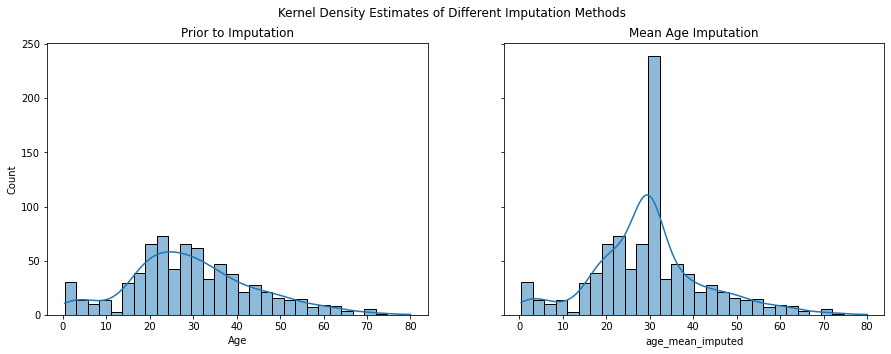

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods')

sns.histplot(ax=axs[0], data=titanic_train_new, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_train_new, x='age_mean_imputed', bins=30, kde=True)
axs[1].set_title('Mean Age Imputation')

The mean imputed age obviously has a large number of age values at the mean age of about 29 years old. This significantly modifies the distribution of the variable, but there are no longer any missing values:

In [18]:
sum(titanic_train_new['age_mean_imputed'].isnull())

0

### Imputation by mean age stratified by class
The data can be stratified by passenger class. The mean age of each passenger class can the be used for a slightly more sophisticated method of imputation.

Define a function to impute the stratified mean age.

In [19]:
# compute the means for each pclass
pclass_1_mean = titanic_train_new[titanic_train_new['Pclass']==1]['Age'].mean()
pclass_2_mean = titanic_train_new[titanic_train_new['Pclass']==2]['Age'].mean()
pclass_3_mean = titanic_train_new[titanic_train_new['Pclass']==3]['Age'].mean()

# define the function to apply to the data frame
def strat_mean_impute(class_age):
    if np.isnan(class_age[1]):
        if class_age[0] == 1:
            return pclass_1_mean
        elif class_age[0] == 2:
            return pclass_2_mean
        else:
            return pclass_3_mean
    else:
        return class_age[1]

Apply the by-class imputation function.

In [20]:
titanic_train_new['age_class_imputed'] = titanic_train_new[['Pclass', 'Age']].apply(strat_mean_impute, axis=1)

Text(0.5, 1.0, 'Class-stratified Age Imputation')

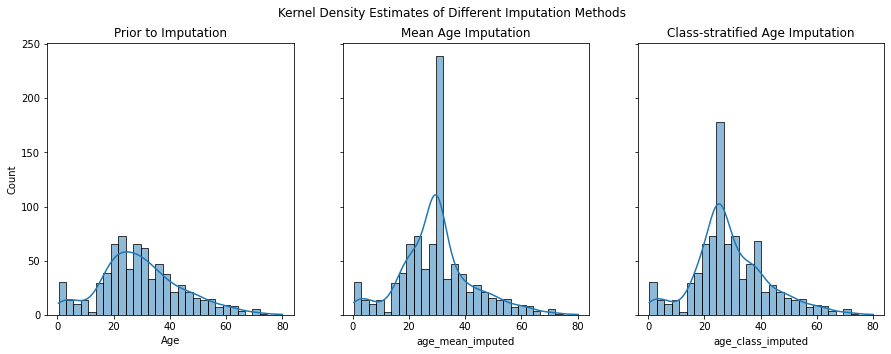

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods')

sns.histplot(ax=axs[0], data=titanic_train_new, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_train_new, x='age_mean_imputed', bins=30, kde=True)
axs[1].set_title('Mean Age Imputation')

sns.histplot(ax=axs[2], data=titanic_train_new, x='age_class_imputed', bins=30, kde=True)
axs[2].set_title('Class-stratified Age Imputation')

In [22]:
# number of passengers in each class
titanic_train_new['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [23]:
# number of missing values in the third class
sum(titanic_train_new[titanic_train_new['Pclass']==3]['Age'].isnull())

136

Though less pronounced, the class-stratified imputation of age still modifies the age distribution significantly. There is no longer as obvious a peak at the mean age, but because the majority of passengers were in 3rd class (n=491), there remains a large peak at the mean age of passengers in 3rd class as they also were the large majority of missing ages as well (n=136).

### KNN imputation

### Multivariate feature imputation
This is an experimental feature in `sklearn`. There are several options for the estimator to use in order to perform the imputation:
- **BayesianRidge:** regularized linear regression
- **DecisionTreeRegressor:** non-linear regression
- **ExtraTreesRegressor:** similar to missForest in R
- **KNeighborsRegressor:** comparable to other KNN imputation approaches

I am most familiar with the `missForest` package in `R`. Based on the <a href=https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py>documentation</a>, the `ExtraTreesRegressor` is most similar. Therefore, the below is performed using this method.

In [24]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Because the iterative imputer fits a model to predict the missing values, the data frame for imputation must be the original data. The categorical variables will remain "dummified" and the string variables are removed.

In [25]:
titanic_mv_impute = titanic_train_new[['Survived', 'Age', 'SibSp', 'Parch', 
                                       'Fare', 'Pclass_2', 'Pclass_3', 'male', 'Q', 'S']]

Perform Extra Trees regression to fill in the missing values.

In [26]:
from sklearn.ensemble import ExtraTreesRegressor

Instantiate the imputer.

In [27]:
imp_tree = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=42))

Fit the Extra Trees Regressor on the missing data.

In [28]:
imp_tree.fit(X=titanic_mv_impute)

IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10,
                                               random_state=42))

Generate an array of the data with the missing values filled in.

In [29]:
titanic_tree_imputed = imp_tree.transform(X=titanic_mv_impute)

Regenerate the data frame.

In [30]:
titanic_tree_imputed = pd.DataFrame(titanic_tree_imputed, columns=titanic_mv_impute.columns)

Plot the age data as above.

Text(0.5, 1.0, 'Tree Age Imputation')

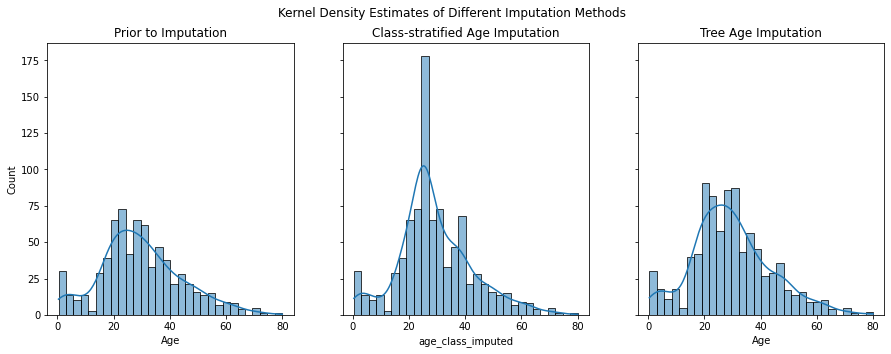

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
fig.suptitle('Kernel Density Estimates of Different Imputation Methods')

sns.histplot(ax=axs[0], data=titanic_train_new, x='Age', bins=30, kde=True)
axs[0].set_title('Prior to Imputation')

sns.histplot(ax=axs[1], data=titanic_train_new, x='age_class_imputed', bins=30, kde=True)
axs[1].set_title('Class-stratified Age Imputation')

sns.histplot(ax=axs[2], data=titanic_tree_imputed, x='Age', bins=30, kde=True)
axs[2].set_title('Tree Age Imputation')

It is clear by the above histograms and kernel density estimates that imputation using an ensemble tree-based method provides the most consistent missingness imputation. The distribution of the tree-imputed ages is quite similar to that of the original data with missing values.